<a href="https://colab.research.google.com/github/Curiousss/EVA/blob/master/Assignment20/Transfer_Resnet_Cifar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os
import numpy as np
import torch

import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [6]:
data_transform = transforms.Compose([transforms.Resize(224), 
                                      transforms.ToTensor()])
trainset = torchvision.datasets.CIFAR100(root='train/',
                                         train=True,
                                         download=True,
                                         transform=data_transform)
testset = torchvision.datasets.CIFAR100(root='test/',
                                        train=False,
                                        download=True,
                                        transform=data_transform)

0it [00:00, ?it/s]

 99%|█████████▉| 167256064/169001437 [00:11<00:00, 33022921.39it/s]

Extracting train/cifar-100-python.tar.gz to train/



0it [00:00, ?it/s]


 98%|█████████▊| 166043648/169001437 [00:06<00:00, 33076890.91it/s]
169009152it [00:06, 27284463.45it/s]                               

Extracting test/cifar-100-python.tar.gz to test/


In [0]:
# define dataloader parameters
batch_size = 20
num_workers=0

# prepare data loaders
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size, 
                                          num_workers=num_workers, shuffle=True)

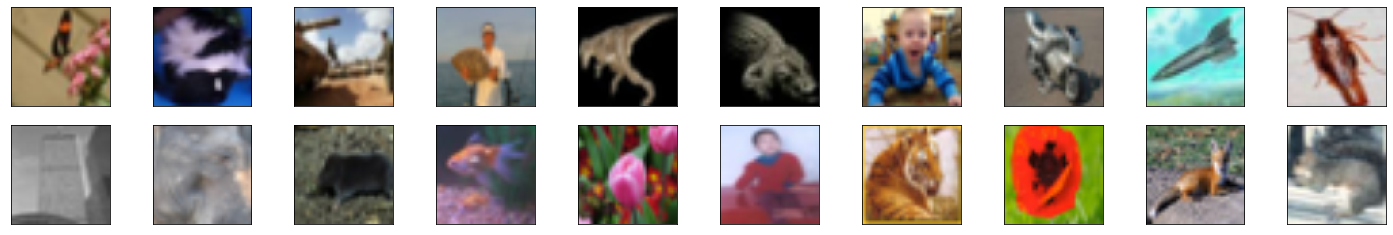

In [8]:
# Visualize some sample data

# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    #ax.set_title(classes[labels[idx]])

In [9]:
# Load the pretrained model from pytorch
#pretrained (bool) – If True, returns a model pre-trained on ImageNet
resnet18 = models.resnet18(pretrained=True)

# print out the model structure
print(resnet18)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth

  0%|          | 0.00/44.7M [00:00<?, ?B/s]
  9%|▉         | 4.06M/44.7M [00:00<00:01, 40.7MB/s]
 19%|█▉        | 8.66M/44.7M [00:00<00:00, 42.6MB/s]
 31%|███       | 13.7M/44.7M [00:00<00:00, 45.1MB/s]
 38%|███▊      | 17.1M/44.7M [00:00<00:00, 41.8MB/s]
 45%|████▌     | 20.2M/44.7M [00:00<00:00, 38.1MB/s]
 62%|██████▏   | 27.8M/44.7M [00:00<00:00, 45.2MB/s]
 72%|███████▏  | 32.2M/44.7M [00:00<00:00, 43.8MB/s]
 83%|████████▎ | 36.9M/44.7M [00:00<00:00, 44.8MB/s]
 92%|█████████▏| 41.3M/44.7M [00:00<00:00, 38.1MB/s]
100%|██████████| 44.7M/44.7M [00:01<00:00, 44.5MB/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [10]:
print(resnet18.fc.in_features) 
print(resnet18.fc.out_features) 

512
1000


In [11]:
# Freeze training for all "features" layers
for param in resnet18.parameters():
    param.requires_grad = False
resnet18.avgpool.requires_grad = True
resnet18.layer4.requires_grad_ = True
print(resnet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [12]:
import torch.nn as nn

n_inputs = resnet18.fc.in_features

last_layer = nn.Linear(n_inputs, 100)

resnet18.fc = last_layer

# if GPU is available, move the model to GPU
if train_on_gpu:
    resnet18.cuda()

# check to see that your last layer produces the expected number of outputs
print(resnet18.fc.out_features)
#print(resnet18)

169009152it [00:30, 33022921.39it/s]                               

100


In [0]:
import torch.optim as optim

# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# specify optimizer (stochastic gradient descent) and learning rate = 0.001
optimizer = optim.SGD(resnet18.parameters(), lr=0.01)

In [60]:
# number of epochs to train the model
n_epochs = 2

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    
    ###################
    # train the model #
    ###################
    # model by default is set to train
    for batch_i, (data, target) in enumerate(train_loader):
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = resnet18(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss 
        train_loss += loss.item()
        
    print('Epoch %d, Batch %d loss: %.16f' %(epoch, batch_i + 1, train_loss / (batch_i)))
    train_loss = 0.0

Epoch 1, Batch 2500 loss: 0.9918745967413054
Epoch 2, Batch 2500 loss: 0.9874658906469349


In [0]:
CIFAR100_LABELS_LIST = [
    'apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 
    'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 
    'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 
    'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 
    'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 
    'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion',
    'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse',
    'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear',
    'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine',
    'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose',
    'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake',
    'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table',
    'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout',
    'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman',
    'worm'
]

In [62]:
test_loss = 0.0
class_correct = list(0. for i in range(100))
class_total = list(0. for i in range(100))

resnet18.eval() # eval mode

# iterate over test data
for data, target in test_loader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = resnet18(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update  test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate avg test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(100):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            CIFAR100_LABELS_LIST[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5d: N/A (no training examples)' % i)

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 1.491093

Test Accuracy of apple: 76% (76/100)
Test Accuracy of aquarium_fish: 69% (69/100)
Test Accuracy of  baby: 41% (41/100)
Test Accuracy of  bear: 50% (50/100)
Test Accuracy of beaver: 30% (30/100)
Test Accuracy of   bed: 62% (62/100)
Test Accuracy of   bee: 64% (64/100)
Test Accuracy of beetle: 57% (57/100)
Test Accuracy of bicycle: 73% (73/100)
Test Accuracy of bottle: 78% (78/100)
Test Accuracy of  bowl: 53% (53/100)
Test Accuracy of   boy: 33% (33/100)
Test Accuracy of bridge: 55% (55/100)
Test Accuracy of   bus: 58% (58/100)
Test Accuracy of butterfly: 50% (50/100)
Test Accuracy of camel: 66% (66/100)
Test Accuracy of   can: 73% (73/100)
Test Accuracy of castle: 71% (71/100)
Test Accuracy of caterpillar: 47% (47/100)
Test Accuracy of cattle: 57% (57/100)
Test Accuracy of chair: 71% (71/100)
Test Accuracy of chimpanzee: 74% (74/100)
Test Accuracy of clock: 80% (80/100)
Test Accuracy of cloud: 68% (68/100)
Test Accuracy of cockroach: 71% (71/100)
Test Accuracy of co

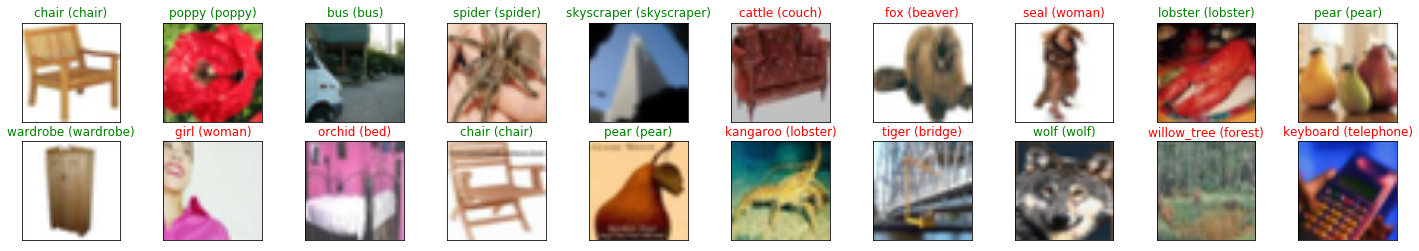

In [64]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
#images.numpy()

# move model inputs to cuda, if GPU available
if train_on_gpu:
    images = images.cuda()

# get sample outputs
output = resnet18(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())
images = images.cpu()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    #print(images[idx])
    plt.imshow(np.transpose(images[idx], (1,2,0)))
    ax.set_title("{} ({})".format(CIFAR100_LABELS_LIST[preds[idx]], CIFAR100_LABELS_LIST[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))